In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report

Notes:
- Make the "skills" be a true/false
- Try another version of the model which has bands, perhaps instead of seniority or exp

In [195]:

# -------------------
# Load and clean data
# -------------------
df = pd.read_csv("/Users/erikborn/Documents/Python/jupyter/Salary_ML/modelData3.csv")

# Clean numeric fields
df["25-26 Salary"] = pd.to_numeric(df["25-26 Salary"].str.replace(",", ""), errors="coerce")
df["Prep Rating"] = pd.to_numeric(df["Prep Rating"], errors="coerce")
df = df.dropna()

# 🔧 Recode Skill Rating to binary: 0 if == 3, 1 if > 3
df["Skill Rating"] = df["Skill Rating"].apply(lambda x: 1 if x > 3 else 0)

#Features selection
features_to_keep = [
    "Years of Exp",
    "Seniority",
    "Skill Rating",
    "Prep Rating",
    "Knowledge Rating"
    # add or remove from here as needed
]

# One-hot encode categorical features
cats = [
    "Level",
    "Gender", 
    "Education Level"]
df_encoded = pd.get_dummies(df, columns=cats, drop_first=True)

#Include other features
categorical_dummies = [col for col in df_encoded.columns if any(prefix in col for prefix in cats)]
features_to_use = features_to_keep + categorical_dummies

X = df_encoded[features_to_use]
y = df_encoded["25-26 Salary"]

In [196]:

# -------------------
# Regression model
# -------------------
from sklearn.model_selection import RepeatedKFold, cross_validate
# X = df_encoded.drop(columns=["25-26 Salary"])
# y = df_encoded["25-26 Salary"]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
model_noOuts = Ridge(alpha=1.0)
scores = cross_validate(
        model_noOuts,
        X,
        y,
        cv=rkf,
        scoring=('r2', 'neg_mean_squared_error'),
        return_train_score=False
    )
r2_scores = scores["test_r2"]
rmse_scores = (-scores["test_neg_mean_squared_error"]) ** 0.5
a=1
print("\n🧪 Ridge Regression Cross-Validation Results:")
print("Alpha\tAvg R²\t\tStd R²\t\tAvg RMSE\t\tStd RMSE")
print(f"{a:<6}\t{np.mean(r2_scores):.4f}\t\t{np.std(r2_scores):.4f}\t\t{np.mean(rmse_scores):,.2f}\t\t{np.std(rmse_scores):,.2f}")



🧪 Ridge Regression Cross-Validation Results:
Alpha	Avg R²		Std R²		Avg RMSE		Std RMSE
1     	0.5960		0.1827		5,885.63		1,075.54


In [197]:
# -------------------
# Outlier detection
# -------------------
model_noOuts.fit(X, y)
df["Prediction"] = model_noOuts.predict(X)
df["Residual"] = df["25-26 Salary"] - df["Prediction"]

# Control outlier threshold as a percent of actual salary
threshold_percent = 0.05
df["Outlier_Flag"] = df["Residual"].abs() > (threshold_percent * df["25-26 Salary"])

# -------------------
# Train classifier to identify outliers
# -------------------
X_class = X.copy()
y_class = df["Outlier_Flag"]

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

probs = clf.predict_proba(X_test)[:, 1]
y_custom = probs > 0.3

print("\n📊 Outlier Classifier Performance (custom threshold):")
print(classification_report(y_test, y_custom))


📊 Outlier Classifier Performance (custom threshold):
              precision    recall  f1-score   support

       False       0.50      0.38      0.43         8
        True       0.44      0.57      0.50         7

    accuracy                           0.47        15
   macro avg       0.47      0.47      0.46        15
weighted avg       0.47      0.47      0.46        15



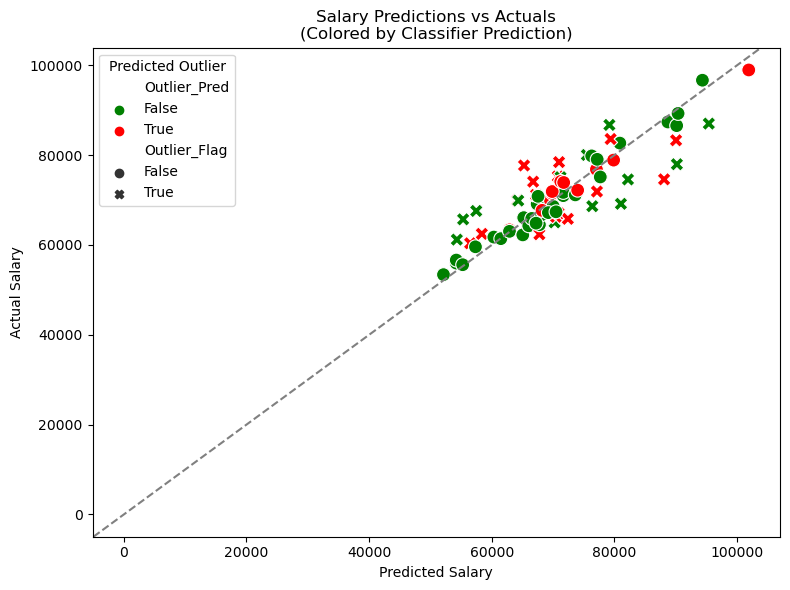

In [198]:
# -------------------
# Visualization
# -------------------
df["Outlier_Prob"] = clf.predict_proba(X_class)[:, 1]
df["Outlier_Pred"] = df["Outlier_Prob"] > 0.4

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="25-26 Salary",
    y="Prediction",
    hue="Outlier_Pred",
    palette={True: "red", False: "green"},
    style="Outlier_Flag",
    markers={True: "X", False: "o"},
    s=100
)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.title("Salary Predictions vs Actuals\n(Colored by Classifier Prediction)")
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")
plt.legend(title="Predicted Outlier")
plt.tight_layout()
plt.show()

In [199]:
from sklearn.model_selection import RepeatedKFold, cross_validate

# Filter to only rows *not* flagged as outliers
df_clean = df[~df["Outlier_Flag"]].copy()

# Match index of rows not flagged as outliers
clean_indices = df_clean.index

# Ensure we use the same features as original X
features_to_use = X.columns.tolist()

# Rebuild X and y using just those rows and the exact same features
X_clean = df_encoded.loc[clean_indices, features_to_use]
y_clean = df.loc[clean_indices, "25-26 Salary"]

# Set up repeated cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=25, random_state=45)

# Ridge model (alpha = 1)
a = 1
model_noOuts = Ridge(alpha=a)

# Run CV
scores = cross_validate(
    model_noOuts,
    X_clean,
    y_clean,
    cv=rkf,
    scoring=('r2', 'neg_mean_squared_error'),
    return_train_score=False
)

# Analyze results
r2_scores = scores["test_r2"]
rmse_scores = (-scores["test_neg_mean_squared_error"]) ** 0.5

# Display
print("\n🧪 Ridge Regression Cross-Validation (Excluding Outliers):")
print(f"Used {len(X_clean):,} data points for training after outlier exclusion.\n")
print("Alpha\tAvg R²\t\tStd R²\t\tAvg RMSE\t\tStd RMSE")
print(f"{a:<6}\t{np.mean(r2_scores):.4f}\t\t{np.std(r2_scores):.4f}\t\t{np.mean(rmse_scores):,.2f}\t\t{np.std(rmse_scores):,.2f}")


🧪 Ridge Regression Cross-Validation (Excluding Outliers):
Used 45 data points for training after outlier exclusion.

Alpha	Avg R²		Std R²		Avg RMSE		Std RMSE
1     	0.8585		0.1790		2,802.56		658.58


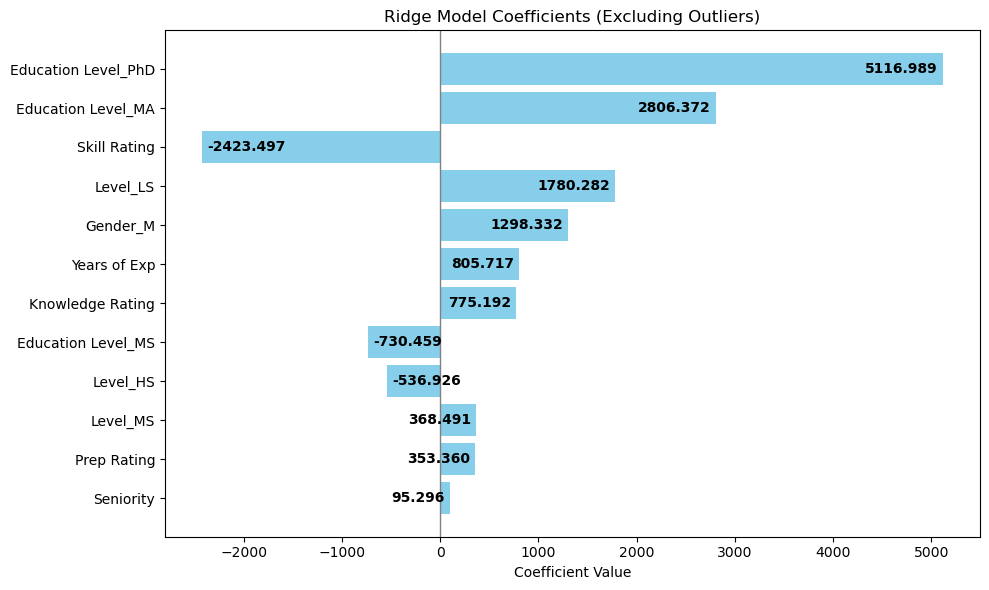

In [200]:
import matplotlib.pyplot as plt

# Fit the model on cleaned data (if not already done)
model_noOuts = Ridge(alpha=1.0)
model_noOuts.fit(X_clean, y_clean)

# Create DataFrame of coefficients
coef_df = pd.DataFrame({
    "Feature": X_clean.columns,
    "Coefficient": model_noOuts.coef_
}).sort_values("Coefficient", key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="skyblue")

# Add text labels inside the bars
for bar, coef in zip(bars, coef_df["Coefficient"]):
    width = bar.get_width()
    text = f"{coef:.3f}"
    xpos = width - 0.01 * max(abs(coef_df["Coefficient"])) if width > 0 else width + 0.01 * max(abs(coef_df["Coefficient"]))
    align = "right" if width > 0 else "left"
    plt.text(
        xpos,
        bar.get_y() + bar.get_height() / 2,
        text,
        va="center",
        ha=align,
        color="black",
        fontweight="bold"
    )

plt.axvline(0, color="gray", linewidth=1)
plt.title("Ridge Model Coefficients (Excluding Outliers)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

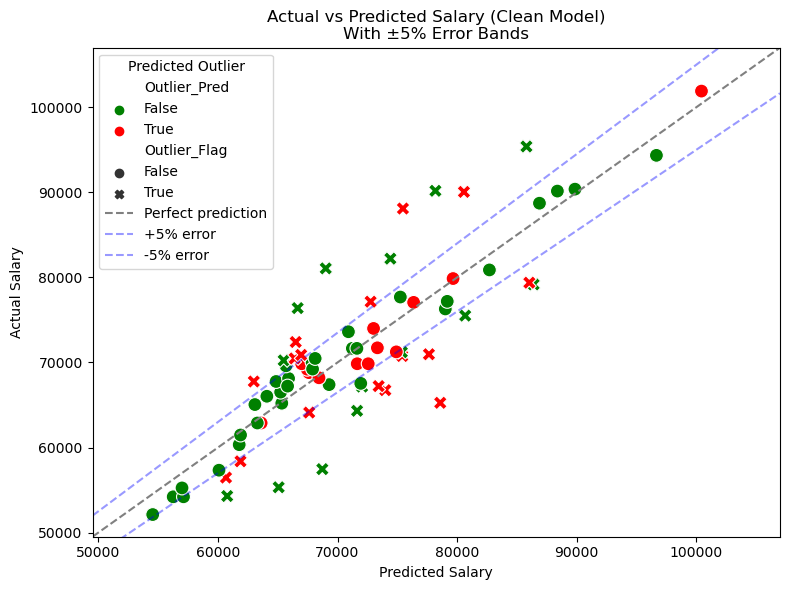

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict using the clean model
X_predict = df_encoded[model_noOuts.feature_names_in_]
df["Prediction_from_clean_model"] = model_noOuts.predict(X_predict)

# Plot setup
plt.figure(figsize=(8, 6))

# Scatterplot: color = predicted outlier, shape = true outlier
sns.scatterplot(
    data=df,
    x="Prediction_from_clean_model",
    y="25-26 Salary",
    hue="Outlier_Pred",
    style="Outlier_Flag",
    palette={True: "red", False: "green"},
    markers={True: "X", False: "o"},
    s=100
)

# Reference lines
lims = [
    min(df["25-26 Salary"].min(), df["Prediction_from_clean_model"].min()) * 0.95,
    max(df["25-26 Salary"].max(), df["Prediction_from_clean_model"].max()) * 1.05,
]

x_vals = np.linspace(lims[0], lims[1], 100)
plt.plot(x_vals, x_vals, "--", color="gray", label="Perfect prediction")
plt.plot(x_vals, x_vals * 1.05, "--", color="blue", alpha=0.4, label="+5% error")
plt.plot(x_vals, x_vals * 0.95, "--", color="blue", alpha=0.4, label="-5% error")

# Labels and layout
plt.title("Actual vs Predicted Salary (Clean Model)\nWith ±5% Error Bands")
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")
plt.xlim(lims)
plt.ylim(lims)
plt.legend(title="Predicted Outlier")
plt.tight_layout()
plt.show()

In [202]:
import plotly.express as px
import numpy as np

# Calculate residual info (if not already done)
df["Residual"] = df["25-26 Salary"] - df["Prediction_from_clean_model"]
df["Residual %"] = df["Residual"] / df["25-26 Salary"]
df["Residual % (abs)"] = df["Residual %"].abs() * 100  # for display
df["Outlier_Pred_Label"] = df["Outlier_Pred"].map({True: "Flagged", False: "Normal"})
df["Outlier_True_Label"] = df["Outlier_Flag"].map({True: "Actual Outlier", False: "Not Outlier"})

# Optional: dummy label for anonymity
df["Label"] = df.index.astype(str)

# Base plot
fig = px.scatter(
    df,
    x="Prediction_from_clean_model",
    y="25-26 Salary",
    color="Outlier_Pred_Label",
    symbol="Outlier_True_Label",
    hover_data={
        "Employee": True,
        "ID": True,
        "25-26 Salary": ":,.0f",
        "Prediction_from_clean_model": ":,.0f",
        "Residual": ":,.0f",
        "Residual % (abs)": ":.1f"
    },
    labels={
        "Prediction_from_clean_model": "Predicted Salary",
        "25-26 Salary": "Actual Salary"
    },
    title="Interactive Prediction vs Actual Salary"
)

# Add ±5% error lines
lims = [
    min(df["25-26 Salary"].min(), df["Prediction_from_clean_model"].min()) * 0.95,
    max(df["25-26 Salary"].max(), df["Prediction_from_clean_model"].max()) * 1.05,
]
x_vals = np.linspace(lims[0], lims[1], 100)

fig.add_scatter(
    x=x_vals, y=x_vals,
    mode='lines', line=dict(dash='dash', color='gray'),
    name='Perfect Prediction'
)
fig.add_scatter(
    x=x_vals, y=x_vals * 1.05,
    mode='lines', line=dict(dash='dot', color='blue'),
    name='+5% Error'
)
fig.add_scatter(
    x=x_vals, y=x_vals * 0.95,
    mode='lines', line=dict(dash='dot', color='blue'),
    name='-5% Error'
)

# Final layout
fig.update_layout(
    xaxis_title="Predicted Salary",
    yaxis_title="Actual Salary",
    legend_title="Predicted Outlier",
    width=900,
    height=600
)

fig.show()

In [203]:
# --------------------------------------------
# Top largest residuals (actual vs predicted)
# --------------------------------------------

# Ensure residuals are computed
df["Residual"] = df["25-26 Salary"] - df["Prediction_from_clean_model"]
df["Residual %"] = (df["Residual"] / df["25-26 Salary"]).abs()

# Sort by absolute residual percentage
top_residuals = df.sort_values("Residual %", ascending=False).copy()

# Choose how many you want to display
n = 10

# Format numeric columns with commas (no decimals)
top_residuals["25-26 Salary (formatted)"] = top_residuals["25-26 Salary"].apply(lambda x: f"{int(round(x)):,}")
top_residuals["Predicted Salary (formatted)"] = top_residuals["Prediction_from_clean_model"].apply(lambda x: f"{int(round(x)):,}")
top_residuals["Residual (formatted)"] = top_residuals["Residual"].apply(lambda x: f"{int(round(x)):,}")
top_residuals["Residual % (formatted)"] = top_residuals["Residual %"].apply(lambda x: f"{x*100:.1f}%")

# Columns to show
display_cols = [
    "Employee",
    "ID",
    "25-26 Salary (formatted)",
    "Predicted Salary (formatted)",
    "Residual (formatted)",
    "Residual % (formatted)",
    "Outlier_Flag",
    "Outlier_Pred",
    "Outlier_Prob"
]

# Show top n
top_residuals[display_cols].head(n)

,Employee,ID,25-26 Salary (formatted),Predicted Salary (formatted),Residual (formatted),Residual % (formatted),Outlier_Flag,Outlier_Pred,Outlier_Prob
62,"Hon, Rebecca M",3245.0,"65,259","78,587","-13,328",20.4%,True,True,0.413225
46,"Turnbull, Jennie",3033.0,"57,463","68,728","-11,265",19.6%,True,False,0.369711
11,"Von Tscharner, Emma M",3161.0,"55,328","65,080","-9,752",17.6%,True,False,0.239279
45,"LaRocque, Carol A",3191.0,"81,055","69,013","12,042",14.9%,True,False,0.289963
67,"Barton, Sarah F",3303.0,"88,090","75,468","12,622",14.3%,True,True,0.495282
68,"Evans, Anne E",2599.0,"90,178","78,183","11,995",13.3%,True,False,0.361367
32,"McHugh, John N",3285.0,"76,387","66,668","9,719",12.7%,True,False,0.387529
4,"Baumgartner, Rachel C",3440.0,"54,302","60,775","-6,473",11.9%,True,False,0.347040
47,"Lantagne, Michael K",3196.0,"64,318","71,634","-7,316",11.4%,True,False,0.307747
33,"Fonseca, Ana J",2600.0,"66,744","73,996","-7,252",10.9%,True,True,0.537729


In [204]:
import shap
import pandas as pd

# Choose row index from original dataset
target_index = 4  # Must be a valid index in df

# Lookup employee info
employee_name = df.loc[target_index, "Employee"]
employee_id = df.loc[target_index, "ID"]
employee_salary = df.loc[target_index, "25-26 Salary"]

# Extract the row for explanation
x_target = X.loc[[target_index]]  # As a DataFrame

# ---------------------------
# Set up custom baseline
# ---------------------------
# Use average row as base, then zero out experience fields
reference_row = X.mean().to_frame().T  # one-row DataFrame
if "Years of Exp" in reference_row.columns:
    reference_row["Years of Exp"] = 0
if "Years Since Hire" in reference_row.columns:
    reference_row["Years Since Hire"] = 0

# Use this reference row for the SHAP explainer
explainer = shap.KernelExplainer(model_noOuts.predict, reference_row)

# Compute SHAP values for this person
shap_values = explainer.shap_values(x_target)

# ---------------------------
# Build the explanation
# ---------------------------
shap_df = pd.DataFrame({
    "Feature": x_target.columns,
    "Value": x_target.iloc[0].values,
    "SHAP Impact": shap_values[0]
}).sort_values("SHAP Impact", key=abs, ascending=False)

shap_df["Direction"] = shap_df["SHAP Impact"].apply(lambda x: "↑ raises" if x > 0 else "↓ lowers")
shap_df["SHAP Impact"] = shap_df["SHAP Impact"].map(lambda x: f"{x:,.0f}")

# ---------------------------
# Display it
# ---------------------------
print(f"📌 SHAP Breakdown for Index {target_index}")
print(f"👤 Employee: {employee_name} (ID: {int(employee_id)})")
print(f"Predicted Salary: ${model_noOuts.predict(x_target)[0]:,.0f}")
print(f"Actual Salary:    ${employee_salary:,.0f}")
print(f"Baseline (0-Exp) Prediction: ${explainer.expected_value:,.0f}\n")
print(shap_df[["Feature", "Value", "SHAP Impact", "Direction"]].head(12).to_string(index=False))

  0%|          | 0/1 [00:00<?, ?it/s]

📌 SHAP Breakdown for Index 4
👤 Employee: Baumgartner, Rachel C (ID: 3440)
Predicted Salary: $60,775
Actual Salary:    $54,302
Baseline (0-Exp) Prediction: $59,492

            Feature Value SHAP Impact Direction
       Years of Exp     3       2,431  ↑ raises
   Knowledge Rating     3      -1,180  ↓ lowers
 Education Level_MA  True       1,025  ↑ raises
       Skill Rating     0         666  ↑ raises
          Seniority     1        -599  ↓ lowers
           Level_LS False        -479  ↓ lowers
        Prep Rating     0        -358  ↓ lowers
           Gender_M False        -294  ↓ lowers
           Level_MS  True         255  ↑ raises
Education Level_PhD False        -185  ↓ lowers
           Level_HS False           0  ↓ lowers
 Education Level_MS False           0  ↓ lowers


In [205]:
import plotly.express as px
import shap
import pandas as pd

# Set the original index from df (can be anything in df)
original_index = target_index  # 👈 change this to whichever row you want to explain

# Make sure that row exists
if original_index not in df_encoded.index:
    raise ValueError(f"Index {original_index} not found in original data!")

# Match exact features used for training
x_target = df_encoded.loc[[original_index], X_clean.columns]

# SHAP: Use KernelExplainer (you already fit model_noOuts earlier)
explainer = shap.KernelExplainer(model_noOuts.predict, X_clean)
shap_values = explainer.shap_values(x_target)

# Create SHAP DataFrame for display
shap_df = pd.DataFrame({
    "Feature": x_target.columns,
    "Value": x_target.iloc[0].values,
    "SHAP Impact": shap_values[0]
})
shap_df["Abs Impact"] = shap_df["SHAP Impact"].abs()
shap_df["Impact Direction"] = shap_df["SHAP Impact"].apply(lambda x: "Raises Prediction" if x > 0 else "Lowers Prediction")
shap_df = shap_df.sort_values("Abs Impact", ascending=True)

baseline = float(explainer.expected_value)  # ensure it's a plain number
title = (
    f"🔍 SHAP Explanation for Index {original_index}<br>"
    f"Predicted: ${model_noOuts.predict(x_target)[0]:,.0f} | "
    f"Baseline: ${baseline:,.0f}"
)

# Interactive plot
fig = px.bar(
    shap_df,
    x="SHAP Impact",
    y="Feature",
    orientation="h",
    color="Impact Direction",
    hover_data={
        "Value": True,
        "SHAP Impact": True,
        "Feature": False,
        "Impact Direction": False
    },
    title=title,
    color_discrete_map={
        "Raises Prediction": "green",
        "Lowers Prediction": "red"
    }
)

fig.update_layout(
    xaxis_title="SHAP Impact on Prediction",
    yaxis_title="Feature",
    height=500
)

fig.show()

  0%|          | 0/1 [00:00<?, ?it/s]

In [206]:
# Prepare HR export DataFrame
hr_export = df.copy()

# Format numeric columns
hr_export["Predicted Salary"] = df["Prediction_from_clean_model"].round(0)
hr_export["Residual"] = (df["25-26 Salary"] - df["Prediction_from_clean_model"]).round(0)
hr_export["Residual %"] = ((hr_export["Residual"] / df["25-26 Salary"]) * 100).round(1)

# Flag columns
hr_export["Recommended for Review"] = df["Outlier_Pred"]
hr_export["Actual Outlier"] = df["Outlier_Flag"]
hr_export["Model Confidence (Outlier %)"] = (df["Outlier_Prob"] * 100).round(1)

# Optional: reformat currency-style columns for HR readability
for col in ["25-26 Salary", "Predicted Salary", "Residual"]:
    hr_export[col] = hr_export[col].apply(lambda x: f"${int(x):,}" if pd.notnull(x) else "")

# Reorder columns to put ID and Employee first, then key model columns
id_columns = ["Employee", "ID"]
key_columns = [
    "25-26 Salary", "Predicted Salary", "Residual", "Residual %",
    "Recommended for Review", "Model Confidence (Outlier %)", "Actual Outlier"
]
other_columns = [col for col in hr_export.columns if col not in id_columns + key_columns]
hr_export = hr_export[id_columns + key_columns + other_columns]

# Sort by % error: lowest residuals (underpaid) at top
hr_export_sorted = hr_export.sort_values("Residual %")

# Export
hr_export_sorted.to_csv("salary_model_output_for_HR_sorted.csv", index=False)

print("✅ Exported: 'salary_model_output_for_HR_sorted.csv' (sorted by Residual %) with Employee and ID first")

✅ Exported: 'salary_model_output_for_HR_sorted.csv' (sorted by Residual %) with Employee and ID first


/var/folders/hk/8yhk12y94z7fwn097_d9fzjh0000gp/T/ipykernel_49161/2986613475.py:38: UserWarning:

Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.



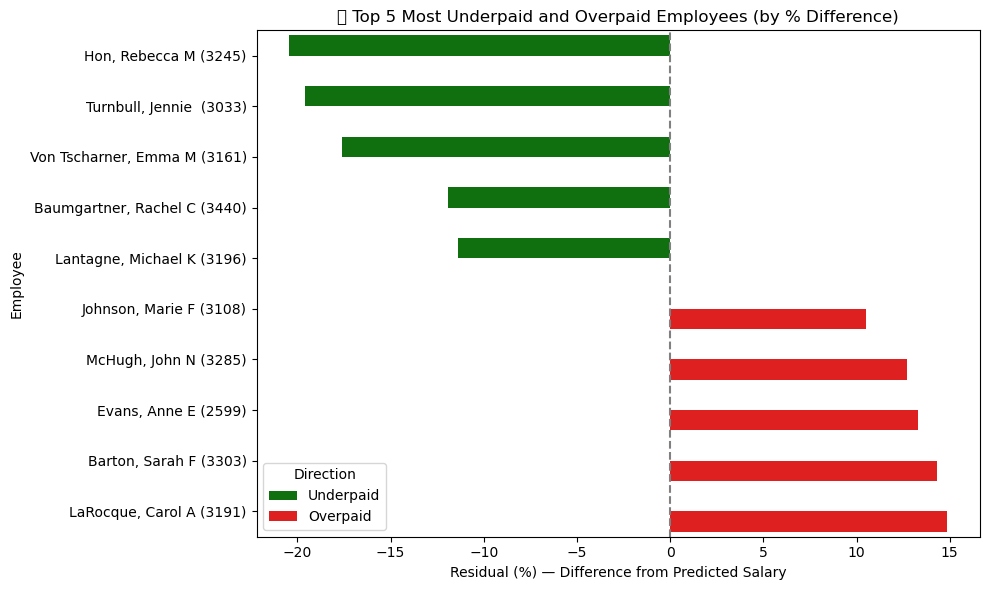

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a working copy
df_viz = df.copy()

# Calculate numeric residual % (if not already done)
df_viz["Residual %"] = (
    (df_viz["25-26 Salary"] - df_viz["Prediction_from_clean_model"]) / df_viz["25-26 Salary"]
) * 100

# Get top 5 underpaid and overpaid employees by percent
top_5 = df_viz.nsmallest(5, "Residual %")  # most underpaid
bottom_5 = df_viz.nlargest(5, "Residual %")  # most overpaid
viz_df = pd.concat([top_5, bottom_5]).copy()

# Sort so the plot flows from most underpaid to most overpaid
viz_df = viz_df.sort_values("Residual %", ascending=True)

# Add labels
viz_df["Residual Direction"] = viz_df["Residual %"].apply(lambda x: "Overpaid" if x > 0 else "Underpaid")
viz_df["Employee Label"] = viz_df["Employee"] + " (" + viz_df["ID"].astype(int).astype(str) + ")"

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=viz_df,
    x="Residual %",
    y="Employee Label",
    hue="Residual Direction",
    palette={"Overpaid": "red", "Underpaid": "green"}
)

plt.axvline(0, color="gray", linestyle="--")
plt.title("💸 Top 5 Most Underpaid and Overpaid Employees (by % Difference)")
plt.xlabel("Residual (%) — Difference from Predicted Salary")
plt.ylabel("Employee")
plt.tight_layout()
plt.legend(title="Direction")
plt.show()

In [208]:
# -----------------------------
# Setup: Choose levels to compare
# -----------------------------
level_A = "HS"  # Options: "LS", "MS", or "HS"
level_B = "LS"

# -----------------------------
# Step 1: Build masks for A and B
# -----------------------------
def build_level_mask(level):
    if level == "HS":
        return df_encoded[["Level_LS", "Level_MS"]].apply(lambda row: not row.any(), axis=1)
    else:
        return df_encoded[f"Level_{level}"] == 1

mask_A = build_level_mask(level_A)
mask_B = build_level_mask(level_B)

# -----------------------------
# Step 2: Feature grouping
# -----------------------------
features_to_compare = [
    "25-26 Salary", "Years of Exp", "Seniority",
    "Skill Rating", "Prep Rating", "Knowledge Rating"
]

# Include one-hot feature columns
one_hot_cols = [col for col in df_encoded.columns if any(prefix in col for prefix in ["Education Level_", "Gender_", "Ethnicity_"])]
all_comparison_cols = features_to_compare + one_hot_cols

# -----------------------------
# Step 3: Summary comparison
# -----------------------------
A_stats = df_encoded.loc[mask_A, all_comparison_cols].agg(["mean", "std"]).T
B_stats = df_encoded.loc[mask_B, all_comparison_cols].agg(["mean", "std"]).T

comparison_df = pd.concat([A_stats, B_stats], axis=1)
comparison_df.columns = [f"{level_A} Mean", f"{level_A} Std", f"{level_B} Mean", f"{level_B} Std"]
comparison_df["Difference (B - A)"] = comparison_df[f"{level_B} Mean"] - comparison_df[f"{level_A} Mean"]
comparison_df = comparison_df.round(3)

# Display nicely
import IPython.display as disp
disp.display(comparison_df.style.format("{:.3f}").set_caption(f"📋 Feature Comparison: {level_A} vs {level_B}"))

# -----------------------------
# Step 4: Predict model salary using average rows
# -----------------------------
X_feature_cols = model_noOuts.feature_names_in_

avg_input_A = df_encoded.loc[mask_A, X_feature_cols].mean().to_frame().T
avg_input_B = df_encoded.loc[mask_B, X_feature_cols].mean().to_frame().T

salary_A = model_noOuts.predict(avg_input_A)[0]
salary_B = model_noOuts.predict(avg_input_B)[0]

# -----------------------------
# Step 5: Print both real and predicted salaries
# -----------------------------
real_avg_A = df_encoded.loc[mask_A, "25-26 Salary"].mean()
real_avg_B = df_encoded.loc[mask_B, "25-26 Salary"].mean()

print(f"\n💰 Predicted Average Salaries (based on model inputs):")
print(f"🔹 Average {level_A} Employee: ${salary_A:,.0f}")
print(f"🔹 Average {level_B} Employee: ${salary_B:,.0f}")
print(f"➡️ Difference ({level_B} - {level_A}): ${salary_B - salary_A:,.0f}")

print(f"\n📊 *Actual* Average Salaries (from raw data):")
print(f"🔹 Average {level_A} Employee: ${real_avg_A:,.0f}")
print(f"🔹 Average {level_B} Employee: ${real_avg_B:,.0f}")
print(f"➡️ Difference ({level_B} - {level_A}): ${real_avg_B - real_avg_A:,.0f}")

,HS Mean,HS Std,LS Mean,LS Std,Difference (B - A)
25-26 Salary,72367.963,10504.246,71322.952,9434.516,-1045.011
Years of Exp,14.593,8.409,15.333,9.687,0.741
Seniority,8.963,9.464,7.286,8.277,-1.677
Skill Rating,0.370,0.492,0.095,0.301,-0.275
Prep Rating,2.593,3.500,0.000,0.000,-2.593
Knowledge Rating,5.926,2.999,3.381,1.024,-2.545
Gender_M,0.185,0.396,0.048,0.218,-0.138
Education Level_MA,0.704,0.465,0.571,0.507,-0.132
Education Level_MS,0.037,0.192,0.000,0.000,-0.037
Education Level_PhD,0.111,0.320,0.000,0.000,-0.111



💰 Predicted Average Salaries (based on model inputs):
🔹 Average HS Employee: $72,265
🔹 Average LS Employee: $71,646
➡️ Difference (LS - HS): $-619

📊 *Actual* Average Salaries (from raw data):
🔹 Average HS Employee: $72,368
🔹 Average LS Employee: $71,323
➡️ Difference (LS - HS): $-1,045
